In [1]:
# Importing necessary libraries
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Connect to the SQLite database
connection = sqlite3.connect('/Users/heather/Documents/CodeRepos/project-4/Cleaned_News.db')

# Query the data from the desired table in the database
query = "SELECT * FROM News_Table"  # Replace 'News_Table' with your actual table name if different
data = pd.read_sql_query(query, connection)

# Display the first few rows of the DataFrame
data.head()



,Text,Class
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [3]:
# Displaying the shape of the dataset (number of rows and columns)
data.shape

(44919, 2)

In [4]:
# Shuffling the dataset to randomize the order of rows
data = data.sample(frac=1) # Shuffle all rows
data.reset_index(inplace=True) # Reset the index after shuffling
data.drop(["index"], axis=1, inplace=True) # Dropping the old index

<Axes: xlabel='Class', ylabel='count'>

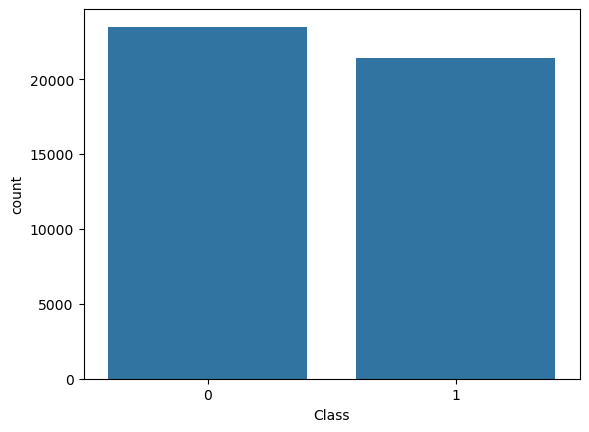

In [5]:
# Visualizing the class distribution using a count plot
# This helps in understanding the balance of the dataset
sns.countplot(data=data,
			x='Class',
			order=data['Class'].value_counts().index)

In [6]:
# Importing additional libraries for text preprocessing and visualization
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /Users/heather/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/heather/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Defining a function to preprocess text data
def preprocess_text(text_data):
	preprocessed_text = []

	for sentence in tqdm(text_data):  # Iterating over all text entries
		# Removing special characters
  		sentence = re.sub(r'[^\w\s]', '', sentence)
		# Tokenizing and removing stopwords
  		preprocessed_text.append(' '.join(token.lower()
								for token in str(sentence).split()
								if token not in stopwords.words('english')))

	return preprocessed_text

In [8]:
# Applying the preprocessing function to the "Text" column
preprocessed_review = preprocess_text(data['Text'].values)
data['Text'] = preprocessed_review

100%|██████████| 44919/44919 [13:35<00:00, 55.06it/s]


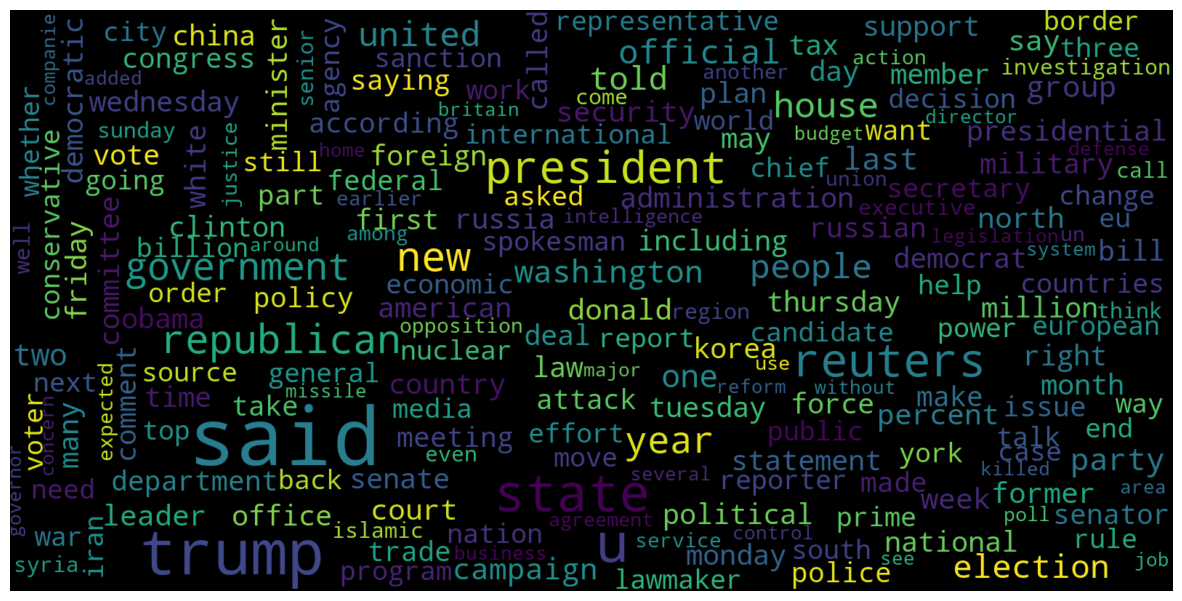

In [9]:
# Generating a WordCloud for Real News (Class = 1)
consolidated = ' '.join(
	word for word in data['Text'][data['Class'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
					height=800,
					random_state=21,
					max_font_size=110,
					collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

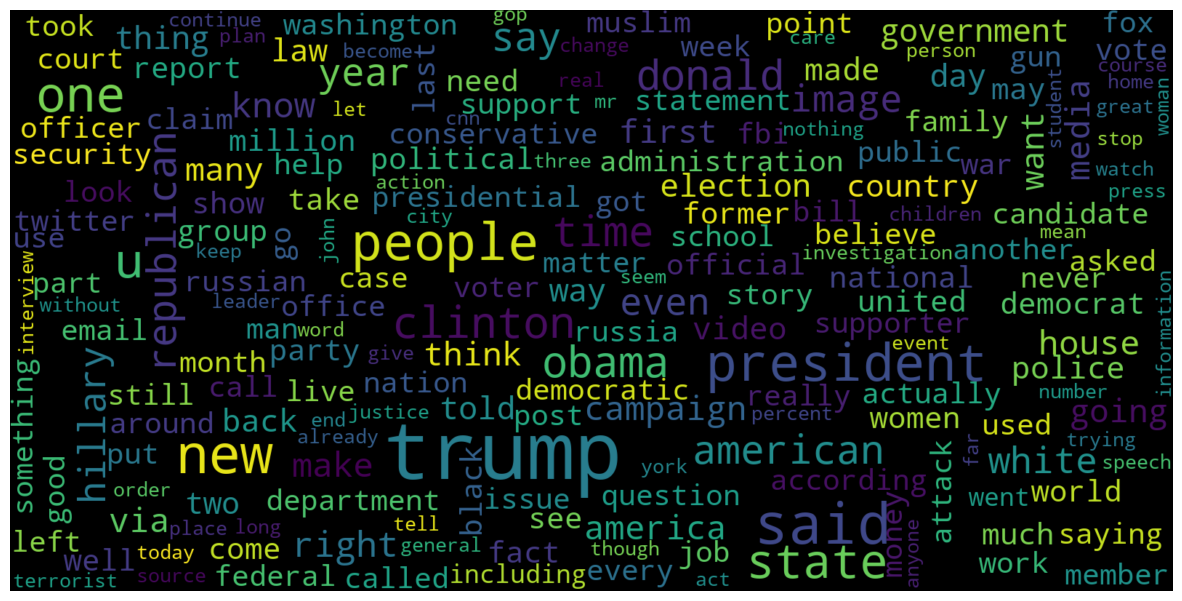

In [10]:
# Generating a WordCloud for Fake News (Class = 0)
consolidated = ' '.join(
	word for word in data['Text'][data['Class'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
					height=800,
					random_state=21,
					max_font_size=110,
					collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

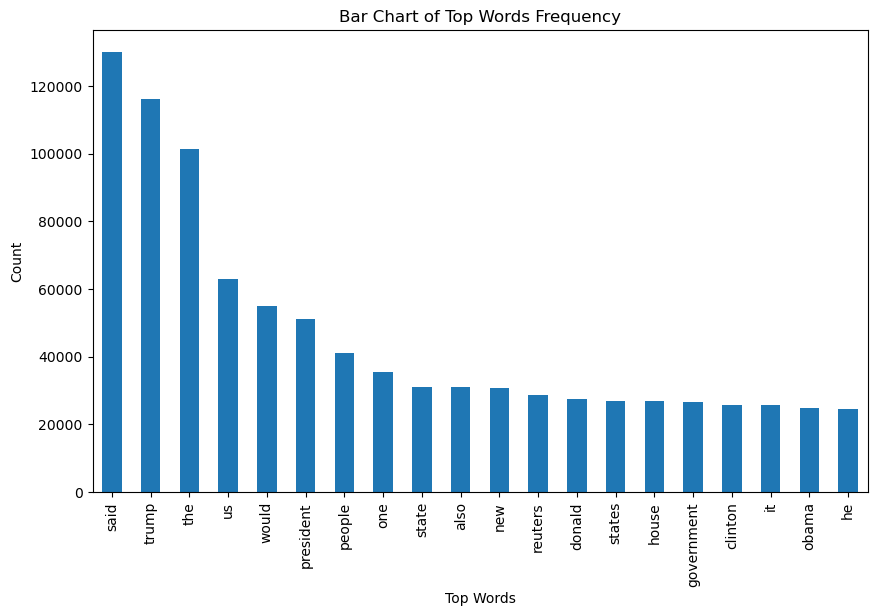

In [11]:
# Importing library for feature extraction
from sklearn.feature_extraction.text import CountVectorizer

# Defining a function to get the top N words in the dataset
def get_top_n_words(corpus, n=None):
	vec = CountVectorizer().fit(corpus) # Vectorizing the corpus
	bag_of_words = vec.transform(corpus) # Transforming text data
	sum_words = bag_of_words.sum(axis=0)
	# Extracting words and their frequency
	words_freq = [(word, sum_words[0, idx])
				for word, idx in vec.vocabulary_.items()]
	words_freq = sorted(words_freq, key=lambda x: x[1],
						reverse=True)
	return words_freq[:n]

# Extracting and visualizing the top 20 most frequent words
common_words = get_top_n_words(data['Text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])

df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
	kind='bar',
	figsize=(10, 6),
	xlabel="Top Words",
	ylabel="Count",
	title="Bar Chart of Top Words Frequency"
)

In [12]:
# Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = train_test_split(data['Text'],
													data['Class'],
													test_size=0.25)

In [13]:
# Transforming text data using TF-IDF vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)

In [14]:
# Training a Logistic Regression model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

# Evaluating the model on training and testing datasets
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

0.9940039775594408
0.9880676758682102


In [15]:
# Training a Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

# Evaluating the model on training and testing datasets
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

0.9999703167205913
0.9969723953695458


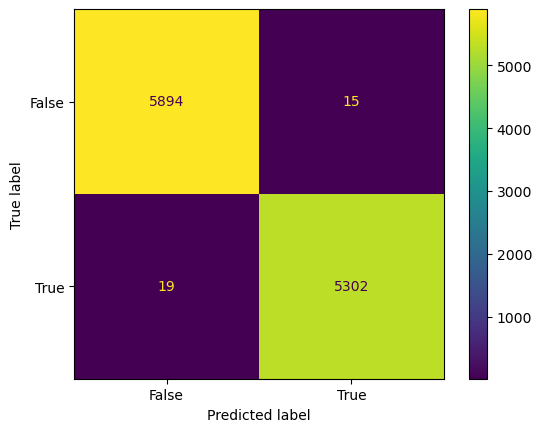

In [16]:
# Visualizing the confusion matrix for Decision Tree classification
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, model.predict(x_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
											display_labels=[False, True])

cm_display.plot()
plt.show()

In [17]:
# Close the database connection
connection.close()